<a href="https://colab.research.google.com/github/pushyag1/Projects/blob/main/Age%26GenderPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center> **Age and Gender Estimation using CNN**

## **Introduction:** 

In this project, we tried to implement the paper "Gil Levi and Tal Hassner. Age and Gender Classification using Convolutional Neural Networks" based on the research supported by ODNI, IARPA. In this paper, the model is implemented using the Caffe open-source framework but we have implemented the same model using pytorch.


> **Paper:** https://talhassner.github.io/home/projects/cnn_agegender/CVPR2015_CNN_AgeGenderEstimation.pdf



> **Dataset :** https://talhassner.github.io/home/projects/Adience/Adience-data.html#agegender


In [ ]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

##**Importing required libraries**

In [ ]:
# importing the required libraries
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import os
from imageio import imread
from glob import glob
import json

import pandas as pd

import time

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [ ]:
from torchsummary import summary

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import * 
from PIL import Image

from google.colab import drive
drive.mount('/content/gdrive/')

import sys
sys.path.append('/content/gdrive/My Drive/MPDL Fall 2020/')

from mpdl import train_network, train_simple_network
from sklearn.metrics import accuracy_score


Mounted at /content/gdrive/


In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import matplotlib.image as img
from IPython.display import display_pdf
from IPython.display import Latex

torch.backends.cudnn.deterministic=True

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

##**Downloading the data**

Images data folder is downloaded into the google data directory and unzipped the folder.

In [ ]:
#!wget --user adiencedb --password adience http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/aligned.tar.gz -P "/content/gdrive/My Drive/DeepLearningproject/data"

In [ ]:
#!tar xvzf "/content/gdrive/My Drive/DeepLearning_project1/data/aligned.tar.gz" -C "/content/gdrive/My Drive/DeepLearningproject/data/"

All the text files(in five folds) used in this project are present here https://github.com/GilLevi/AgeGenderDeepLearning/tree/master/Folds/train_val_txt_files_per_fold

> For this project we are using only one fold of data among the five i.e., test_fold_is_0. These files are downloaded to the drive.


In [ ]:
txt_file = '/content/gdrive/MyDrive/DeepLearningproject/data/data_fold/test_fold_is_0/gender_train_subset.txt'
root_dir = "/content/gdrive/MyDrive/DeepLearningproject/data/aligned"

> Loading the text data which has path of the images and label (GENDER)

In [ ]:
df_gender = pd.read_csv('/content/gdrive/MyDrive/DeepLearningproject/data/data_fold/test_fold_is_0/gender_train_subset.txt', sep=' ',header=None)
df_gender.columns = ['Image_path', 'Label']
df_gender.head()

,Image_path,Label
0,10069023@N00/landmark_aligned_face.1924.103359...,0
1,114841417@N06/landmark_aligned_face.489.120774...,1
2,7464014@N04/landmark_aligned_face.961.10109081...,1
3,28754132@N06/landmark_aligned_face.608.1154649...,1
4,10543088@N02/landmark_aligned_face.662.1004478...,1


In [ ]:
df_gender['Label'].value_counts()

1    734
0    620
Name: Label, dtype: int64

In [ ]:
df_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354 entries, 0 to 1353
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_path  1354 non-null   object
 1   Label       1354 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 21.3+ KB


#### One Hot encoding for gender dataset

In [ ]:
df_gen=pd.get_dummies(df_gender, columns=['Label']) #onehot encoding 

In [ ]:
df_gen

,Image_path,Label_0,Label_1
0,10069023@N00/landmark_aligned_face.1924.103359...,1,0
1,114841417@N06/landmark_aligned_face.489.120774...,0,1
2,7464014@N04/landmark_aligned_face.961.10109081...,0,1
3,28754132@N06/landmark_aligned_face.608.1154649...,0,1
4,10543088@N02/landmark_aligned_face.662.1004478...,0,1
...,...,...,...
1349,11008464@N06/landmark_aligned_face.970.1034966...,0,1
1350,10280355@N07/landmark_aligned_face.1864.113670...,0,1
1351,115126086@N07/landmark_aligned_face.1145.12076...,1,0
1352,114987449@N03/landmark_aligned_face.645.120550...,0,1


In [ ]:
idx=1353
df_gen.iloc[idx,-2:]  #label reference

Label_0    1
Label_1    0
Name: 1353, dtype: object

In [ ]:
df_gen.iloc[:,-2:]  #displaying label columns 

,Label_0,Label_1
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
1349,0,1
1350,0,1
1351,1,0
1352,0,1


In [ ]:
idx=0
label = df_gen.iloc[idx,-2:]

In [ ]:
label1 = torch.tensor((label), dtype=torch.float32)

In [ ]:
label1

tensor([1., 0.])

In [ ]:
df_gender.isnull().sum()

Image_path    0
Label         0
dtype: int64

#### Loading the text data which has path of the images and label (Age)

In [ ]:
df_age = pd.read_csv('/content/gdrive/MyDrive/DeepLearningproject/data/data_fold/test_fold_is_0/age_train_subset.txt', sep=' ',header=None)
df_age.columns = ['Image_path', 'Label']
df_age.head()

,Image_path,Label
0,10069023@N00/landmark_aligned_face.1924.103359...,5
1,7464014@N04/landmark_aligned_face.961.10109081...,4
2,28754132@N06/landmark_aligned_face.608.1154649...,2
3,10543088@N02/landmark_aligned_face.662.1004478...,3
4,66870968@N06/landmark_aligned_face.1227.113262...,4


In [ ]:
df_age['Label'].value_counts()

4    303
5    199
2    194
1    161
0    160
3    152
7     68
6     58
Name: Label, dtype: int64

In [ ]:
df_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_path  1295 non-null   object
 1   Label       1295 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [ ]:
df_age.isnull().sum()

Image_path    0
Label         0
dtype: int64

In [ ]:
df_ag=pd.get_dummies(df_age, columns=['Label']) #onehot encoding for age labels
df_ag

,Image_path,Label_0,Label_1,Label_2,Label_3,Label_4,Label_5,Label_6,Label_7
0,10069023@N00/landmark_aligned_face.1924.103359...,0,0,0,0,0,1,0,0
1,7464014@N04/landmark_aligned_face.961.10109081...,0,0,0,0,1,0,0,0
2,28754132@N06/landmark_aligned_face.608.1154649...,0,0,1,0,0,0,0,0
3,10543088@N02/landmark_aligned_face.662.1004478...,0,0,0,1,0,0,0,0
4,66870968@N06/landmark_aligned_face.1227.113262...,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
1290,45668969@N05/landmark_aligned_face.1624.118710...,0,0,0,0,1,0,0,0
1291,10280355@N07/landmark_aligned_face.1864.113670...,0,0,0,0,0,1,0,0
1292,115126086@N07/landmark_aligned_face.1145.12076...,0,0,0,0,0,0,1,0
1293,114987449@N03/landmark_aligned_face.645.120550...,0,1,0,0,0,0,0,0


In [ ]:
df_ag.iloc[idx,-8:]

Label_0    0
Label_1    0
Label_2    0
Label_3    0
Label_4    0
Label_5    1
Label_6    0
Label_7    0
Name: 0, dtype: object

### Looking at Sample Images

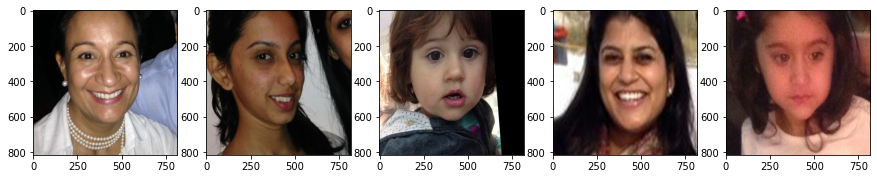

In [ ]:
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(df_gender[df_gender['Label'] == 1]['Image_path'][-5:]):
    path = os.path.join(root_dir,idx)
    ax[i].imshow(img.imread(path))

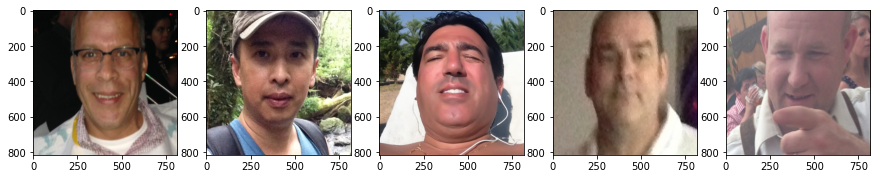

In [ ]:
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(df_gender[df_gender['Label'] == 0]['Image_path'][-5:]):
    path = os.path.join(root_dir,idx)
    ax[i].imshow(img.imread(path))

## **Defining the Class Dataset**

#### Gender class Dataset

In [ ]:
class GenderDataset(Dataset):
    """Gender dataset."""

    def __init__(self, data, root_dir, transform=None):
        """
        Args:
            data(csv_file (string)): Path to the csv file with labels and image paths.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_df = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.data_df.iloc[idx, 0])
        
        image_read = imread(img_name)
        
        label = self.data_df.iloc[idx,-2:]
        #label = torch.from_numpy(label).type(torch.FloatTensor)
        label = torch.tensor((label), dtype=torch.float32)
        
        #label=label.unsqueeze(0)
        #label = torch.unsqueeze(label,0)
        #print(label)

 

        if self.transform:
          image = self.transform(image_read)

        sample = (image, label)

        return sample

#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

#### Age class Dataset

In [ ]:
class AgeDataset(Dataset):
    """Age dataset."""

    def __init__(self, data, root_dir, transform=None):
        """
        Args:
            data(csv_file (string)): Path to the csv file with labels and image paths.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_df = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.data_df.iloc[idx, 0])
        
        image_read = imread(img_name)
        
        label = self.data_df.iloc[idx,-8:]
        #label = torch.from_numpy(label).type(torch.FloatTensor)
        label = torch.tensor((label), dtype=torch.float32)
        
        
        #label=label.unsqueeze(-1)
        #label = torch.unsqueeze(label,0)
        #print(label)

 

        if self.transform:
          image = self.transform(image_read)

        sample = (image, label)

        return sample

#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

### Image transforms

In [ ]:
image_transforms = transforms.Compose([
                         transforms.ToPILImage(),                      
                         transforms.Resize((256,256)),
                         transforms.RandomCrop((227,227)),
                         transforms.ToTensor()])

### 1. Gender dataset

In [ ]:
gender_dataset=GenderDataset(df_gen, root_dir, transform=image_transforms)

In [ ]:
gender_dataset[0]

(tensor([[[0.4784, 0.3216, 0.2784,  ..., 0.0706, 0.0706, 0.0667],
          [0.4627, 0.2980, 0.2588,  ..., 0.0588, 0.0627, 0.0627],
          [0.3961, 0.2745, 0.2431,  ..., 0.0627, 0.0667, 0.0627],
          ...,
          [0.7686, 0.7647, 0.8471,  ..., 0.7725, 0.6980, 0.7176],
          [0.7882, 0.8863, 0.9020,  ..., 0.7098, 0.6902, 0.7608],
          [0.8980, 0.8549, 0.7333,  ..., 0.6863, 0.7686, 0.8157]],
 
         [[0.3569, 0.2000, 0.1608,  ..., 0.0549, 0.0549, 0.0510],
          [0.3373, 0.1765, 0.1373,  ..., 0.0431, 0.0471, 0.0471],
          [0.2706, 0.1490, 0.1216,  ..., 0.0471, 0.0510, 0.0471],
          ...,
          [0.8196, 0.8157, 0.8980,  ..., 0.8157, 0.7451, 0.7608],
          [0.8392, 0.9373, 0.9529,  ..., 0.7490, 0.7294, 0.8000],
          [0.9490, 0.9059, 0.7843,  ..., 0.7255, 0.8078, 0.8549]],
 
         [[0.2510, 0.0902, 0.0510,  ..., 0.0471, 0.0471, 0.0471],
          [0.2431, 0.0745, 0.0353,  ..., 0.0392, 0.0431, 0.0431],
          [0.1804, 0.0588, 0.0275,  ...,

### splitting the data for gender

In [ ]:
train_gender_split, test_gender_split = torch.utils.data.random_split(gender_dataset, [1000, len(gender_dataset)-1000])
train_loader_g = DataLoader(train_gender_split, batch_size=16, shuffle=True)
test_loader_g = DataLoader(test_gender_split,  batch_size=16)

In [ ]:
len(train_loader_g)

63

In [ ]:
len(test_loader_g)

23

In [ ]:
# Checking the shape of the data
batch = iter(train_loader_g)
image, label = batch.next()
print(image[1].shape)
print(label.shape)


torch.Size([3, 227, 227])
torch.Size([16, 2])


#### Printing a sample image for gender

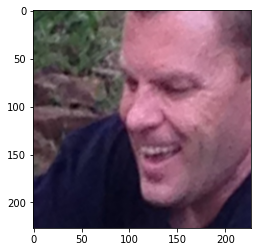

In [ ]:
img = image[1]
numpyimage = img.numpy()
numpyimage = np.transpose(numpyimage, (1,2,0))

plt.figure()
plt.imshow(numpyimage)
plt.show()


* Gender label 1 represents Female
* Gender label 0 represents Male

## **2. Age dataset**

In [ ]:
age_dataset = AgeDataset(df_ag, root_dir, transform = image_transforms)

In [ ]:
age_dataset[0]

(tensor([[[0.8549, 0.7098, 0.6392,  ..., 0.0941, 0.0941, 0.0980],
          [0.8549, 0.7529, 0.6588,  ..., 0.0902, 0.0941, 0.0941],
          [0.7490, 0.7216, 0.6784,  ..., 0.0863, 0.0902, 0.0863],
          ...,
          [0.7922, 0.7451, 0.7608,  ..., 0.6745, 0.6353, 0.6902],
          [0.7412, 0.8157, 0.8588,  ..., 0.6275, 0.6941, 0.7765],
          [0.8627, 0.8784, 0.8039,  ..., 0.6784, 0.7412, 0.7137]],
 
         [[0.7373, 0.5922, 0.5216,  ..., 0.0627, 0.0627, 0.0667],
          [0.7373, 0.6353, 0.5333,  ..., 0.0588, 0.0627, 0.0667],
          [0.6314, 0.6039, 0.5490,  ..., 0.0549, 0.0627, 0.0667],
          ...,
          [0.8431, 0.7961, 0.8118,  ..., 0.7059, 0.6667, 0.7255],
          [0.7922, 0.8667, 0.9098,  ..., 0.6667, 0.7255, 0.8118],
          [0.9137, 0.9294, 0.8549,  ..., 0.7176, 0.7725, 0.7490]],
 
         [[0.5961, 0.4510, 0.3804,  ..., 0.0510, 0.0510, 0.0549],
          [0.6000, 0.4980, 0.3961,  ..., 0.0471, 0.0510, 0.0549],
          [0.4980, 0.4706, 0.4118,  ...,

In [ ]:
train_age_split, test_age_split = torch.utils.data.random_split(age_dataset, [800, len(age_dataset)-800])
train_loader_a = DataLoader(train_age_split, batch_size=16, shuffle=True)
test_loader_a = DataLoader(test_age_split,  batch_size=16)

In [ ]:
len(train_loader_a)

50

In [ ]:
len(test_loader_a)

31

In [ ]:
# Checking the shape of the data
batch = iter(train_loader_a)
image, label = batch.next()
print(image[1].shape)
print(label.shape)


torch.Size([3, 227, 227])
torch.Size([16, 8])


#### Printing a sample image for age

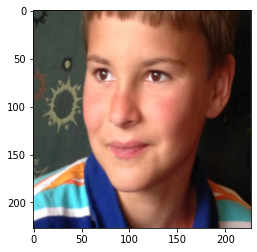

In [ ]:
img = image[1]
numpyimage = img.numpy()
numpyimage = np.transpose(numpyimage, (1,2,0))

plt.figure()
plt.imshow(numpyimage)
plt.show()

   * Age label 0  represents '0-2 years',
   * Age label 1  represents '4-6 years',
   * Age label 2  represents  '8-13 years',
   * Age label 3  represents  '15-20 years',
   * Age label 4  represents  '25-32 years',
   * Age label 5  represents  '38-43 years',
   * Age label 6  represents  '48-53 years',
   * Age label 7  represents  '60 years and above',

### Defining the Neural Network

#### Model 1 for Gender 

In [ ]:
C = 3 # channels
filters= 96 # number of filters 
D = 227*227 # dimensions of image

#pooling shrinks the width and height of image by factor of K^n,here K is 2 and n is number of rounds


model_cnn_pool_g = nn.Sequential(   
    nn.Conv2d(C, filters, 7, padding=7//2),    
    nn.Tanh(),
    nn.Conv2d(filters, filters, 7, padding=7//2),    
    nn.Tanh(),  
    nn.MaxPool2d(2), 
    nn.Conv2d(filters, filters, 7, padding=7//2),    
    nn.Tanh(),   
    nn.MaxPool2d(2),  
    nn.Conv2d(filters, 2*filters, 5, padding=5//2),    
    nn.Tanh(),   
    nn.Conv2d(2*filters, 2*filters, 5, padding=5//2),    
    nn.Tanh(),
    nn.MaxPool2d(2),   
    nn.Conv2d(2*filters, 2*filters, 5, padding=5//2),    
    nn.Tanh(),   
    nn.MaxPool2d(2), 
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),    
    nn.Tanh(),   
    nn.MaxPool2d(2),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),    
    nn.Tanh(),   
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(1728,2) 
)


In [ ]:
loss_func = nn.BCEWithLogitsLoss() #Binary cross entropy loss
model_1g_results = train_network(model_cnn_pool_g, loss_func, train_loader_g, val_loader=test_loader_g, epochs=10, device=device,
                                 checkpoint_file= 'model_g1.pt' ,score_funcs={'Accuracy': accuracy_score}) #scoring fns

In [ ]:
model_1g_results

Text(0.5, 1.0, 'Train loss Vs Validation Loss')

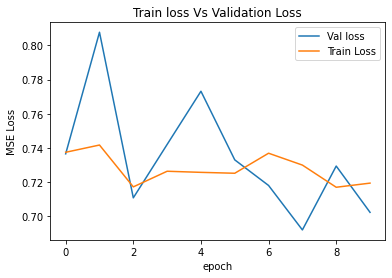

In [ ]:
sns.lineplot(x='epoch', y='val loss', data=model_1g_results, label='Val loss')
sns.lineplot(x='epoch', y='train loss', data=model_1g_results, label='Train Loss')
plt.ylabel("MSE Loss")
plt.title("Train loss Vs Validation Loss")

#### **Defining the network model as per the published paper**

![alt text](https://drive.google.com/uc?id=1-EDtsls9n29_6EjGELTodCX2PpmHgrC_)


In [ ]:
C = 3
classes = 2 #gender classes
model_2_g = nn.Sequential(
    nn.Conv2d(3,96,7,stride =4, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.LocalResponseNorm(size=5,alpha=0.0001,beta= 0.75),
    nn.Conv2d(96,256,5,stride= 1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.LocalResponseNorm(size=5,alpha=0.0001,beta= 0.75),
    nn.Conv2d(256,384,3,stride= 1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.LocalResponseNorm(size=5,alpha=0.0001,beta= 0.75),
    nn.Flatten(),
    nn.Linear(18816,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,2),
    nn.Softmax(dim=1)
    )

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
model_2g_results = train_network(model_2_g,loss_func, train_loader_g, val_loader=test_loader_g, epochs=40, device=device,
                                checkpoint_file='model2g.pt') 

In [ ]:
model_2g_results

Text(0.5, 1.0, 'Train loss Vs Validation loss')

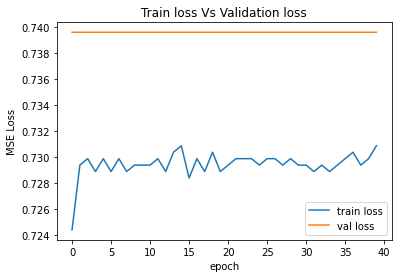

In [ ]:
sns.lineplot(x='epoch', y='train loss', data=model_2g_results, label='train loss')
sns.lineplot(x='epoch', y='val loss', data=model_2g_results, label='val loss')
plt.ylabel("MSE Loss")
plt.title("Train loss Vs Validation loss")

#### Model 1 Age 

In [ ]:
C = 3 # channels
filters= 96 # number of filters 
D = 227*227 # dimensions of image
classes=8 # output classes
#pooling shrinks the width and height of image by factor of K^n,here K is 2 and n is number of rounds

model_1_a = nn.Sequential(   
    nn.Conv2d(C, filters, 7, padding=7//2),    
    nn.Tanh(),
    nn.Conv2d(filters, filters, 7, padding=7//2),    
    nn.Tanh(),  
    nn.MaxPool2d(2), 
    nn.Conv2d(filters, filters, 7, padding=7//2),    
    nn.Tanh(),   
    nn.MaxPool2d(2),  
    nn.Conv2d(filters, 2*filters, 5, padding=5//2),    
    nn.Tanh(),   
    nn.Conv2d(2*filters, 2*filters, 5, padding=5//2),    
    nn.Tanh(),
    nn.MaxPool2d(2),   
    nn.Conv2d(2*filters, 2*filters, 5, padding=5//2),    
    nn.Tanh(),   
    nn.MaxPool2d(2), 
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),    
    nn.Tanh(),   
    nn.MaxPool2d(2),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),    
    nn.Tanh(),   
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(1728,8) # batch size * w * H
)


In [ ]:
loss_func = nn.BCEWithLogitsLoss()
model_1a_results = train_network(model_1_a, loss_func, train_loader_a, val_loader=test_loader_a, epochs=10, device=device,
                                 checkpoint_file= 'model_a1.pt' ) #scoring fns

In [ ]:
model_1a_results

,epoch,total time,train loss,val loss,train Accuracy,val Accuracy
0,0,75.785634,0.404898,0.385882,NaN,NaN
1,1,139.263174,0.395425,0.382484,NaN,NaN
2,2,202.887218,0.387000,0.372224,NaN,NaN
3,3,266.629383,0.386955,0.396931,NaN,NaN
4,4,330.635982,0.395610,0.434152,NaN,NaN
5,5,394.819584,0.392390,0.375407,NaN,NaN
6,6,458.829243,0.380867,0.384773,NaN,NaN
7,7,522.905110,0.383826,0.376784,NaN,NaN
8,8,587.057438,0.385344,0.393813,NaN,NaN
9,9,651.326689,0.384202,0.391470,NaN,NaN


Text(0.5, 1.0, 'Train loss Vs Validation Loss')

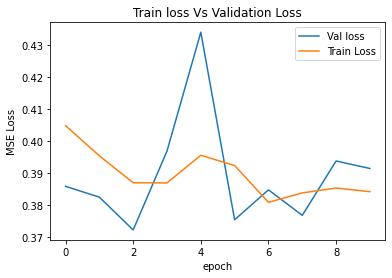

In [ ]:
sns.lineplot(x='epoch', y='val loss', data=model_1a_results, label='Val loss')
sns.lineplot(x='epoch', y='train loss', data=model_1a_results, label='Train Loss')
plt.ylabel("MSE Loss")
plt.title("Train loss Vs Validation Loss")

#### Model for Age as per the paper

In [ ]:
C = 3
classes = 8 #age classes
model_2_a = nn.Sequential(
    nn.Conv2d(3,96,7,stride =4, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.LocalResponseNorm(size=5,alpha=0.0001,beta= 0.75),
    nn.Conv2d(96,256,5,stride= 1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.LocalResponseNorm(size=5,alpha=0.0001,beta= 0.75),
    nn.Conv2d(256,384,3,stride= 1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=2, padding=1),
    nn.LocalResponseNorm(size=5,alpha=0.0001,beta= 0.75),
    nn.Flatten(),
    nn.Linear(18816,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,8),
    nn.Softmax(dim=1)
    )

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
model_2a_results = train_network(model_2_a,loss_func, train_loader_a, val_loader=test_loader_a, epochs=40, device=device,
                                checkpoint_file='model2a.pt') 

In [ ]:
model_2a_results

Text(0.5, 1.0, 'Train loss Vs Validation Loss')

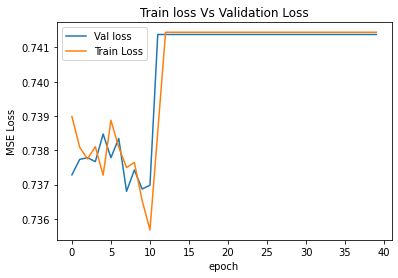

In [ ]:
sns.lineplot(x='epoch', y='val loss', data=model_2a_results, label='Val loss')
sns.lineplot(x='epoch', y='train loss', data=model_2a_results, label='Train Loss')
plt.ylabel("MSE Loss")
plt.title("Train loss Vs Validation Loss")